# Momentum Backtest

NOTE: The backtest includese all the assets as per strategy specifications. The graphs are only shown for sanity checks and for a subset of securities. For further details please see the code.


In [304]:
from src.data_request import BloombergAPI
from datetime import datetime
import pandas as pd
import numpy  as np

import warnings
warnings.filterwarnings('ignore')

index_specifications = {'WTI_Crude'  :{'Symbol':'CL1 Comdty','Weight':0.05 ,'Vol_Scale_Cap':1.147},
                        'Brent_Crude':{'Symbol':'CO1 Comdty','Weight':0.05 ,'Vol_Scale_Cap':1.331},
                        'Heating_Oil':{'Symbol':'HO1 Comdty','Weight':0.025,'Vol_Scale_Cap':1.458},
                        'RBOB'       :{'Symbol':'XB1 Comdty','Weight':0.025,'Vol_Scale_Cap':1.198},
                        'Gas_Oil'    :{'Symbol':'QS1 Comdty','Weight':0.025,'Vol_Scale_Cap':1.462},
                        'NatGas'     :{'Symbol':'NG1 Comdty','Weight':0.100,'Vol_Scale_Cap':0.836},
                        
                        'Gold'       :{'Symbol':'GC1 Comdty','Weight':0.100,'Vol_Scale_Cap':2.646},
                        'Silver'     :{'Symbol':'SI1 Comdty','Weight':0.050,'Vol_Scale_Cap':1.510},
                        'Copper'     :{'Symbol':'LP1 Comdty','Weight':0.075,'Vol_Scale_Cap':1.737},
                        
                        'Aluminium'  :{'Symbol':'LA1 Comdty','Weight':0.075,'Vol_Scale_Cap':1.926},
                        'Zinc'       :{'Symbol':'LX1 Comdty','Weight':0.050,'Vol_Scale_Cap':1.775},
                        'Nickel'     :{'Symbol':'LN1 Comdty','Weight':0.035,'Vol_Scale_Cap':0.932},
                        'Lead'       :{'Symbol':'LL1 Comdty','Weight':0.005,'Vol_Scale_Cap':1.532},
                        
                        'Corn'       :{'Symbol':'C 1 Comdty','Weight':0.075,'Vol_Scale_Cap':1.824},
                        'Soybean'    :{'Symbol':'S 1 Comdty','Weight':0.075,'Vol_Scale_Cap':1.600},
                        'Wheat'      :{'Symbol':'W 1 Comdty','Weight':0.050,'Vol_Scale_Cap':1.614},
                        
                        'Sugar'      :{'Symbol':'SB1 Comdty','Weight':0.035,'Vol_Scale_Cap':1.117},
                        'Coffee'     :{'Symbol':'KC1 Comdty','Weight':0.020,'Vol_Scale_Cap':1.121},
                        'Cocoa'      :{'Symbol':'CC1 Comdty','Weight':0.005,'Vol_Scale_Cap':1.275},
                        'Cotton'     :{'Symbol':'CT1 Comdty','Weight':0.020,'Vol_Scale_Cap':1.821},
                        
                        'LiveCattle' :{'Symbol':'LC1 Comdty','Weight':0.035,'Vol_Scale_Cap':2.739},
                        'LeanHogs'   :{'Symbol':'LH1 Comdty','Weight':0.020,'Vol_Scale_Cap':1.568},
                        
                       }

symbols = [ index_specifications[s]['Symbol'] for s in list(index_specifications.keys())]


benchmarks = ['NMEDMG3E Index','NMCOOA1U Index']


In [189]:
print('Selected symbols are: ',symbols)

Selected symbols are:  ['CL1 Comdty', 'CO1 Comdty', 'HO1 Comdty', 'XB1 Comdty', 'QS1 Comdty', 'NG1 Comdty', 'GC1 Comdty', 'SI1 Comdty', 'LP1 Comdty', 'LA1 Comdty', 'LX1 Comdty', 'LN1 Comdty', 'LL1 Comdty', 'C 1 Comdty', 'S 1 Comdty', 'W 1 Comdty', 'SB1 Comdty', 'KC1 Comdty', 'CC1 Comdty', 'CT1 Comdty', 'LC1 Comdty', 'LH1 Comdty']


# Data Exploration

The data we use here comes from Bloomberg. The code below utilizes the Bloombergs Python API to pull data directly from Bloombergs servers. After downloading the data lets plot the it to make sure it makes sense :)

In [305]:
# Download data for traded instruments
data_handler = BloombergAPI(SERVER_HOST='localhost',SERVER_PORT=8194)
start_date   = datetime(1980,1,1)
end_date     = datetime.today()
price_data   = []
for symbol in symbols:
    print('Downloading data for symbol :',symbol)
    try:
        bloomberg_symbol = symbol+' US Equity'
        data = data_handler.send_request([symbol],["PX_LAST"],start_date,end_date)
        if(len(data[symbol])!=0):
            f = pd.DataFrame.from_dict(data[symbol],orient='index')
            f.columns = [symbol]
            price_data.append(f.copy())
    except:
        print(f"Could not download data for {symbol}")

price_data       = pd.concat(price_data,axis=1)
price_data.index = pd.DatetimeIndex(price_data.index)

# Download data for benchmark indices
benchmark_data   = []
for symbol in benchmarks:
    print('Downloading data for symbol :',symbol)
    try:
        bloomberg_symbol = symbol+' US Equity'
        data = data_handler.send_request([symbol],["PX_LAST"],start_date,end_date)
        if(len(data[symbol])!=0):
            f = pd.DataFrame.from_dict(data[symbol],orient='index')
            f.columns = [symbol]
            benchmark_data.append(f.copy())
    except:
        print(f"Could not download data for {symbol}")
benchmark_data = pd.concat(benchmark_data,axis=1)
benchmark_data.index = pd.DatetimeIndex(benchmark_data.index)


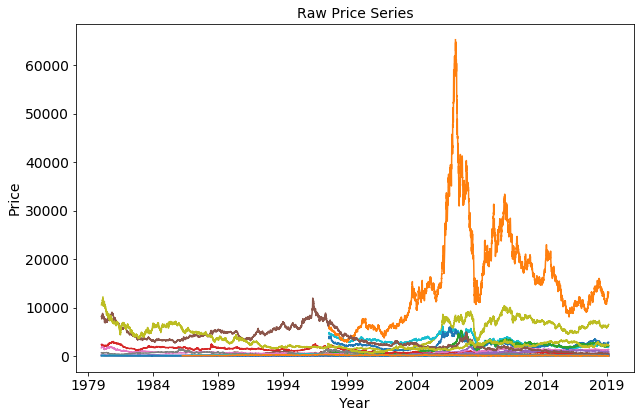

In [191]:
# Lets plot the data
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6.4))
plt.plot(price_data)
plt.ylabel('Price',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Raw Price Series',fontsize=14)
plt.show()


# Momentum Signal Computation

The momentum signal for some asset $i$ is here defined as the simple average of scaled individual signals. The process of computing the scaled signals begins by first computing raw unscaled signals. Each individual raw unscaled signal for asset $i$ is computed as the average of lagged $w$ returns:

$$\mu_{i,w}(t)=\sum_{j=0}^{w}\frac{r_{i,t-j}}{w}$$

The problem with the raw signals are that they have different variances. The scaled signal is then obtained by dividing the raw signal by its own 1250 day standard deviation $\sigma_{1250}(\mu_{i,w})$, i.e.:

$$s_{w}(t)=Max\left(-1;Min\left(1;\frac{\mu_{i,w}(t)}{\sigma_{1250}(\mu_{i,w})(t)}\right)\right)$$

Additionally, we impose limits to the magnitude of signal such that $s_{w}(t) \in \left[ -1,1\right]$ to prohibit excessive positions. The final momentum signal for asset $i$ is then obtained by taking a simple average of signals $s_{w}(t) , \forall w = \{ 60,120,250\}$
 
 
# 1. Raw Signals:

$$\mu_{i,w}(t)=\sum_{j=0}^{w}\frac{r_{i,t-j}}{w}$$



In [192]:
def unscaled_momentum_signal(returns,lookback_window):
    return returns.rolling(lookback_window).mean()

# Return computation
ret = price_data.pct_change(1)

lookback_windows = [66,132,250]

# We allocate dictionary for the signal dataframes
raw_signals = {}

#Raw unscaled signal computation
for symbol in symbols:
    f = {}
    for window in lookback_windows:
        f.update({window:unscaled_momentum_signal(ret[symbol],window)})
    raw_signals.update({symbol:f})



Lets plot the raw signal for WTI Crude Oil to see if it makes sense.

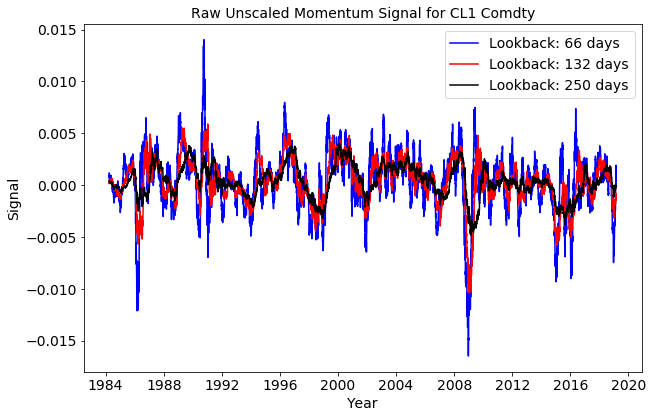

In [193]:
symb = 'CL1 Comdty'

signal_data = pd.DataFrame.from_dict(raw_signals[symb],orient='columns').dropna()

plot_colors = {66:'blue',132:'red',250:'black'}


fig = plt.figure(figsize=(10,6.4))
for h in signal_data:
    plt.plot(signal_data[h],label=f'Lookback: {h} days',color=plot_colors[h])
plt.ylabel('Signal',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'Raw Unscaled Momentum Signal for {symb}',fontsize=14)
plt.legend(fontsize=14)
plt.show()

# 2. Scaled Signal

From the plot above we notice that the variances of the signals for different $w$ have different variances. To obtain the unit variance signals we use the following formula for the scaled signals:

$$s_{w}(t)=Max\left(-1;Min\left(1;\frac{\mu_{i,w}(t)}{\sigma_{1250}(\mu_{i,w})(t)}\right)\right)$$

In [194]:
def scaled_signal(raw_signal,window):
    
    return (raw_signal.div(raw_signal.rolling(window).std())).clip(-1,1)

# Window for signal normalization
sigma_w = 1250

# We allocate dictionary for the signal dataframes
scaled_signals = {}

#Raw unscaled signal computation
for symbol in symbols:
    f = {}
    for window in lookback_windows: 
        f.update({window:scaled_signal(raw_signals[symbol][window],sigma_w)})
    scaled_signals.update({symbol:f})


Again, lets plot the scaled signal for WTI Crude Oil to see if the scaled signal looks OK.

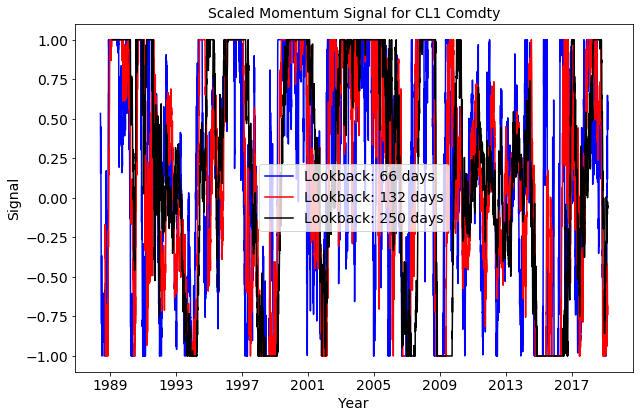

In [195]:
symb = 'CL1 Comdty'

signal_data = pd.DataFrame.from_dict(scaled_signals[symb],orient='columns')

plot_colors = {66:'blue',132:'red',250:'black'}

fig = plt.figure(figsize=(10,6.4))
for h in signal_data:
    
    plt.plot(signal_data[h],label=f'Lookback: {h} days',color=plot_colors[h])
plt.ylabel('Signal',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'Scaled Momentum Signal for {symb}',fontsize=14)
plt.legend(fontsize=14)
plt.show()

# 3. Final Momentum Signal

The following code computes the final momentum signals given by:

$$s_i(t)=\frac{1}{3}\sum_{j=1}^{3}s_{w_{j}} = \frac{1}{3}\sum_{j=1}^{3}Max\left(-1;Min\left(1;\frac{\mu_{i,w_{j}}(t)}{\sigma_{1250}(\mu_{i,w_{j}})(t)}\right)\right)$$

In [196]:
def final_signal(signals):
    
    fs = signals.mean(axis=1).to_frame()
    
    return fs
    
# We allocate a list for the signal dataframes
final_signals = []

#Raw unscaled signal computation
for symbol in symbols:
    df = pd.DataFrame.from_dict(scaled_signals[symbol],orient='columns')
    fs = final_signal(df)
    fs.columns = [symbol]
    final_signals.append(fs)
final_signals = pd.concat(final_signals,axis=1)


Again, lets plot the final signal for WTI Crude Oil to see if itlooks OK.

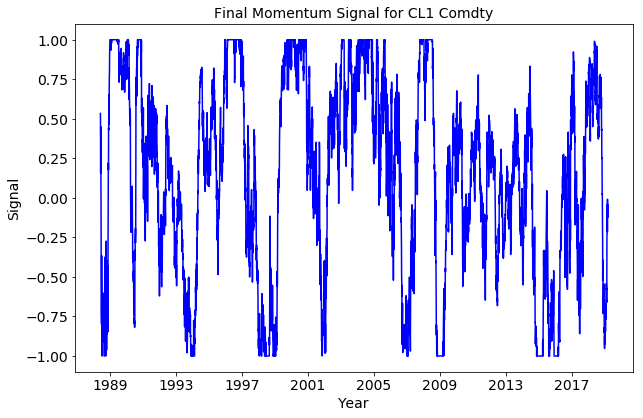

In [197]:
symb = 'CL1 Comdty'

fig = plt.figure(figsize=(10,6.4))
plt.plot(final_signals[symb],color='blue')
plt.ylabel('Signal',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'Final Momentum Signal for {symb}',fontsize=14)
plt.show()



# Volatility Scaling:
The next thing we need is the volatility scaling mechanism. The idea behind this is that since the time-series for volatility have strong auto-correlation then it is possible to create locally constant volatility time series using a clever weighting scheme:

$$L_{\sigma}(t)=Min\left[ Cap; \frac{\sigma_T}{\sigma_R(t)} \right]$$

where $\sigma_T$ is our target volatility which is here set to 10\% p.a. and $\sigma_R$ is the realized volatility in annualized terms. Here we use 63 window to calculate the realized volatility. However, the window can be anything you want. The term $Cap$ is the maximum leverage cap we impose to our volatility imposed leverage. Here se set $Cap=1$. However, this cap can be anything you want.


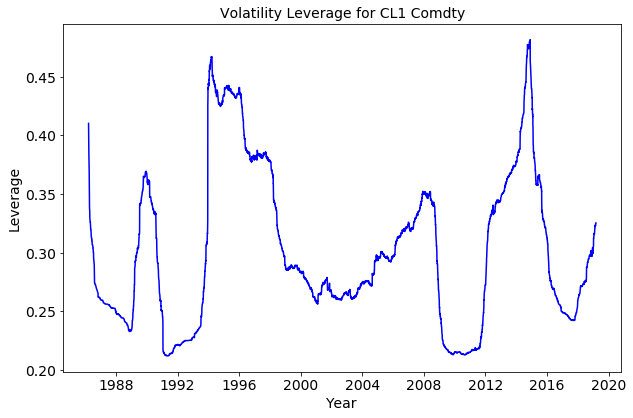

In [285]:
# Target volatility (per annum)
target_volatility = 0.10

# volatility window
sigma_windoww = 750

# Lets compute the volatility leverages for each individual underlying
L_sigmas = {}
for k,v in index_specifications.items():
    
    symbol = index_specifications[k]['Symbol']
    
    vol_scale_cap = index_specifications[k]['Vol_Scale_Cap']
    
    # Raw volatility leverage
    L_sigma = target_volatility/(ret[symbol].rolling(sigma_windoww).std().dropna()*np.sqrt(250))
    
    # Impose leverage cap as per strategy specifications
    L_sigma = L_sigma.clip(0,vol_scale_cap)
    
    L_sigmas.update({symbol:L_sigma})

    
L_sigmas = pd.DataFrame.from_dict(L_sigmas,orient='columns')
    

symb = 'CL1 Comdty'

fig = plt.figure(figsize=(10,6.4))
plt.plot(L_sigmas[symb],color='blue')
plt.ylabel('Leverage',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'Volatility Leverage for {symb}',fontsize=14)
plt.show()



# Backtest

Now we are ready to compute the historical backtest of the strategy. Here the position is determined by the product of trading signal and the volatility leverage. That is, the total exposure in asset $i$ at time $t$, $E_{i}(t)$ is defined as:

$$E_{i}(t):=L_{\sigma}(t)s_i(t)$$

Then the return on the position is computed as:

$$R_{i}(t) = E_{i}(t-1)\left( \frac{S_{t}-S_{t-1}}{S_{t-1}} \right)$$

In [300]:
exposure = (L_sigmas.shift(1)*final_signals.shift(1)).fillna(0)

# Strategy returns using weights from index specifications
strat_rets = {}
for k,v in index_specifications.items():
    
    symbol       = index_specifications[k]['Symbol']
    index_weight = index_specifications[k]['Weight']
    
    # Momentum strategy exposure for "symbol"
    E = exposure[symbol]
    
    # Daily futures returns for "symbol"
    symbol_rets = ret[symbol]
    
    # Momentum strategy returns for "symbol"
    mom_ret = (E*symbol_rets).fillna(0)
    
    strat_rets.update({k:mom_ret.copy()})
     
strat_rets = pd.DataFrame.from_dict(strat_rets,orient='columns')#exposure*ret

# Cumulative performance assuming compounding
xs = (1.0+strat_rets.mean(axis=1)).cumprod()
xx = (1.0+strat_rets).cumprod()

from dateutil.relativedelta import relativedelta

start_date = xs.head(1).index[0]
end_date   = xs.tail(1).index[0]
years      = (end_date - start_date).days/365


# Statistics
mu_avg  = strat_rets.mean(axis=1).mean()*252
mu_cagr = (xs.tail(1).values[0]/xs.head(1).values[0])**(1.0/years)-1.0
i       = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
j       = np.argmax(xs[:i]) # start of period
max_dd  = (xs[i] - xs[j])/xs[j]
vol     = strat_rets.mean(axis=1).std()*np.sqrt(250)
sharpe  = mu/vol

from scipy.stats import skew,kurtosis

print('Average return       : ', round(100.0*mu_avg ,2), '% p.a.')
print('CAGR                 : ', round(100.0*mu_cagr,2), '% p.a.')
print('Volatility           : ', round(100.0*vol,2)    , '% p.a.')
print('Sharpe               : ', round(mu_cagr/vol,2))
print('Max DD               : ', round(100.0*max_dd,2))
print('Max DD Start         : ', j.date())
print('Max DD End           : ', i.date())
print('Calmar Ratio (Avg)   : ', round(mu_avg  / abs(max_dd),3))
print('Calmar Ratio (CAGR)  : ', round(mu_cagr / abs(max_dd),3))
print('Max DD / Vol         : ', round(max_dd/vol,2))
print('Skew                 : ', round(skew(xs),2))
print('Kurtosis (Fisher)    : ', round(kurtosis(xs,fisher=True),2))




Average return       :  1.25 % p.a.
CAGR                 :  1.26 % p.a.
Volatility           :  2.19 % p.a.
Sharpe               :  0.57
Max DD               :  -6.26
Max DD Start         :  2016-01-20
Max DD End           :  2019-02-06
Calmar Ratio (Avg)   :  0.2
Calmar Ratio (CAGR)  :  0.201
Max DD / Vol         :  -2.86
Skew                 :  0.45
Kurtosis (Fisher)    :  -1.36


# Performance Plots

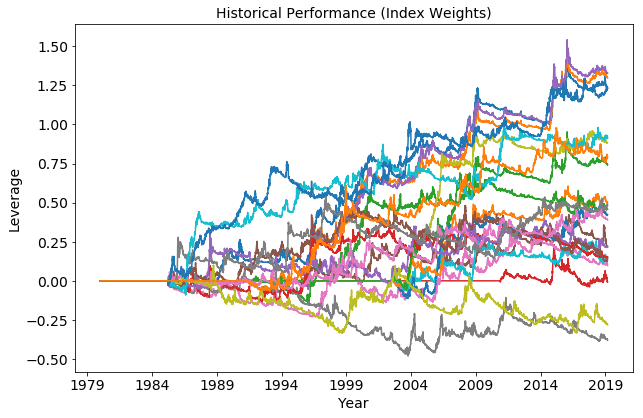

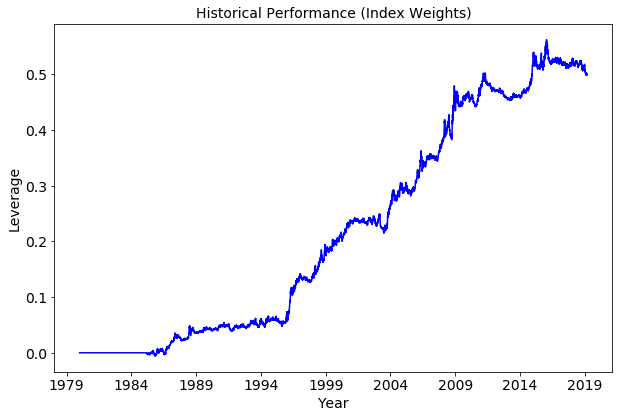

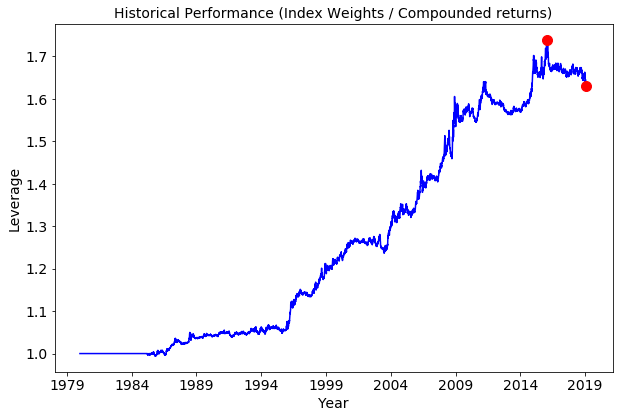

In [301]:
fig = plt.figure(figsize=(10,6.4))
plt.plot(strat_rets.cumsum())
plt.ylabel('Leverage',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'Historical Performance (Index Weights)',fontsize=14)
plt.show()

fig = plt.figure(figsize=(10,6.4))
plt.plot(strat_rets.mean(axis=1).cumsum(),color='blue')
plt.ylabel('Leverage',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'Historical Performance (Index Weights)',fontsize=14)
plt.show()


fig = plt.figure(figsize=(10,6.4))
plt.plot(xs,color='blue')
plt.plot([i, j], [xs[i], xs[j]], 'o', color='Red', markersize=10)
plt.ylabel('Leverage',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'Historical Performance (Index Weights / Compounded returns)',fontsize=14)
plt.show()





# Distribution of Returns

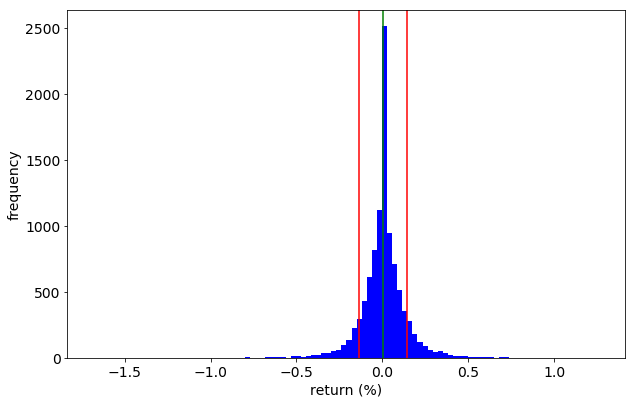

In [318]:
mean  = strat_rets.mean(axis=1).mean()*100
sigma = strat_rets.mean(axis=1).std()*100

fig = plt.figure(figsize=(10,6.4))
plt.hist(strat_rets.mean(axis=1)*100,bins=100,color='blue')
plt.ylabel('frequency',fontsize=14)
plt.xlabel('return (%)',fontsize=14)
plt.axvline(x = mean, color='green')
plt.axvline(x = mean + sigma, color='red')
plt.axvline(x = mean - sigma, color='red')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'',fontsize=14)
plt.show()


# Benchmarking

How does my implementation compare against benchmark strategies? Here we want to make a fair comparison, i.e. scale the strategies to have similar volatilities.

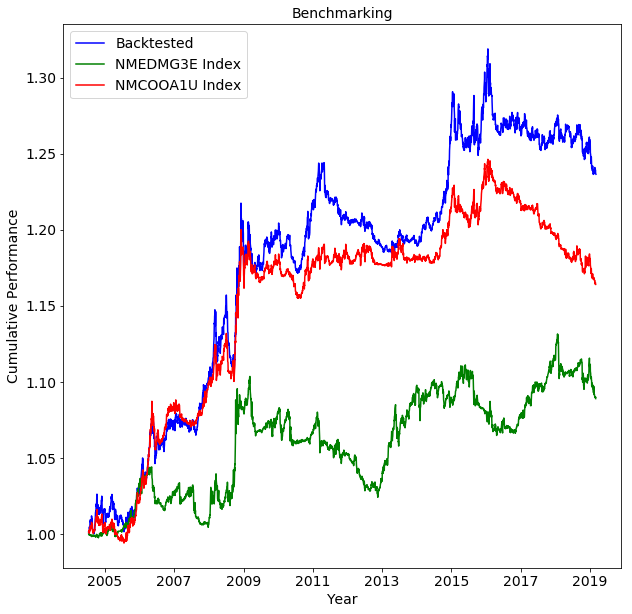

In [326]:
benchmark_returns = benchmark_data.pct_change(1).fillna(0)

benchmark_start_date = datetime(2004,7,14)

my_rets    = strat_rets.mean(axis=1).loc[benchmark_start_date:]

bm_1_ret   = benchmark_returns['NMEDMG3E Index'].loc[benchmark_start_date:]
bm_2_ret   = benchmark_returns['NMCOOA1U Index'].loc[benchmark_start_date:]
bm_1_sigma = bm_1_ret.std()*np.sqrt(250)
bm_2_sigma = bm_2_ret.std()*np.sqrt(250)

bm_1_scale = vol/bm_1_sigma
bm_2_scale = vol/bm_2_sigma

bm_1_ret_scaled = bm_1_scale*bm_1_ret
bm_2_ret_scaled = bm_2_scale*bm_2_ret

y_1  = (1.0 + bm_1_ret_scaled).cumprod()
y_2  = (1.0 + bm_2_ret_scaled).cumprod()
y_my = (1.0 + my_rets).cumprod()


fig = plt.figure(figsize=(10,10))
plt.plot(y_my, color = 'blue'  , label = 'Backtested')
plt.plot(y_1 , color = 'green' , label = 'NMEDMG3E Index')
plt.plot(y_2 , color = 'red'   , label = 'NMCOOA1U Index')
plt.ylabel('Cumulative Performance',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'Benchmarking',fontsize=14)
plt.legend(fontsize=14)
plt.show()





# Performance Comparison Between Backtested and Benchmark Strategies

In [328]:
def compute_statistics(returns):

    # For maximum drawdown we need compounded return series (not strictly correct but hey whatever)
    xs = (1.0 + returns).cumprod()
    
    start_date = xs.head(1).index[0]
    end_date   = xs.tail(1).index[0]
    years      = (end_date - start_date).days/365
    
    # Sample mean
    mu_avg  = returns.mean()*252
    
    # Cumulative aggregate growth rate
    mu_cagr = (xs.tail(1).values[0]/xs.head(1).values[0])**(1.0/years)-1.0
    
    # End of maximum drawdown
    i       = np.argmax(np.maximum.accumulate(xs) - xs) 
    
    # Start of maximum drawdown
    j       = np.argmax(xs[:i])
    
    # Magnitude of maximum drawdown
    max_dd  = (xs[i] - xs[j])/xs[j]
    
    # Volatility of the returns
    vol     = returns.std()*np.sqrt(250)
     
    # Sharpe ratio    
    sharpe  = mu_cagr/vol
    
    result = {}
    
    result.update({'Average_return' :round(100.0*mu_avg ,2) })
    result.update({'CAGR'           :round(100.0*mu_cagr,2) })
    result.update({'Volatility'     :round(100.0*vol,2)     })
    result.update({'Sharpe'         :round(mu_cagr/vol,2)   })
    result.update({'MaxDD'          :round(100.0*max_dd,2)  })
    result.update({'CalmarRatioAvg' :round(mu_avg  / abs(max_dd),3) })
    result.update({'CalmarRatioCAGR':round(mu_cagr / abs(max_dd),3) })
    result.update({'MaxDDperVol'    :round(max_dd/vol,2)               })
    result.update({'Skew'           :round(skew(xs),2)                 })
    result.update({'ExcessKurtosis' :round(kurtosis(xs,fisher=True),2) })
    
    return result


In [339]:
my_stats   = compute_statistics(my_rets)
bm_1_stats = compute_statistics(bm_1_ret)
bm_2_stats = compute_statistics(bm_2_ret)   

df_my = pd.DataFrame.from_dict(my_stats  ,orient='index',columns=['My Commodity Momentum'])
df_1  = pd.DataFrame.from_dict(bm_1_stats,orient='index',columns=['NMEDMG3E Index'])
df_2  = pd.DataFrame.from_dict(bm_2_stats,orient='index',columns=['NMCOOA1U Index'])

summary = pd.concat([df_my,df_1,df_2],axis=1)

print(summary)

                 My Commodity Momentum  NMEDMG3E Index  NMCOOA1U Index
Average_return                   1.460           1.240           3.920
CAGR                             1.450           1.180           3.730
Volatility                       2.920           4.610           8.360
Sharpe                           0.500           0.260           0.450
MaxDD                           -6.260         -14.690         -23.260
CalmarRatioAvg                   0.233           0.084           0.169
CalmarRatioCAGR                  0.231           0.080           0.160
MaxDDperVol                     -2.140          -3.190          -2.780
Skew                            -0.720          -0.200          -0.880
ExcessKurtosis                  -0.690          -1.100          -0.390
